_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: *Jannis Ahlert, Julius Grote , Hun Seok Choi*

LLM Disclaimer: *Github Copilot and Chat gpt, used for autompletion and debugging.*

# Coding Lab 3

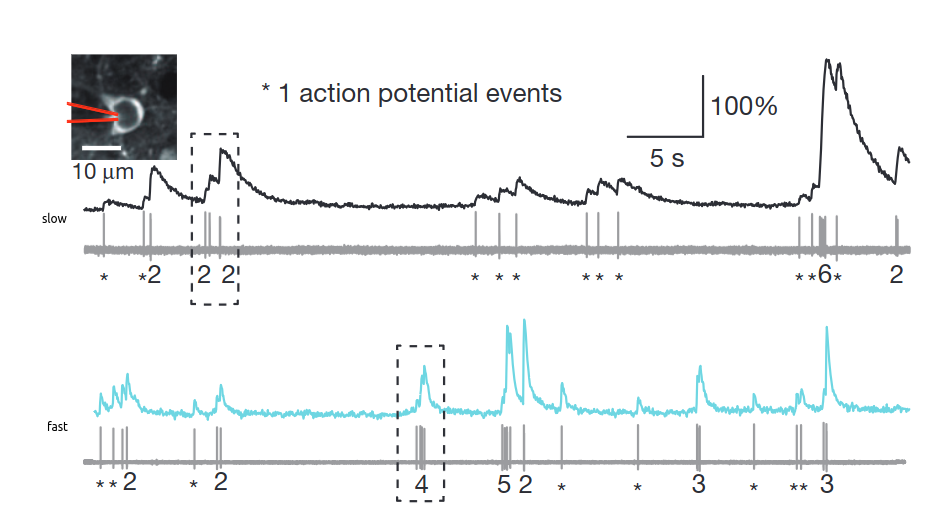

In this notebook you will work with 2 photon calcium recordings from mouse V1 and retina. For details see [Chen et al. 2013](https://www.nature.com/articles/nature12354) and [Theis et al. 2016](https://www.cell.com/neuron/pdf/S0896-6273(16)30073-3.pdf). Two-photon imaging is widely used to study computations in populations of neurons. 

In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For easier analysis, please resample it to 25 Hz. `scipy.signal.decimate` can help here, but note that it is only meant for continous signals. 

__Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```. Note, some recordings were of shorter duration, hence their columns are padded. 

In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --time_smoothzone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


UsageError: unrecognized arguments: --time_smoothzone


In [127]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [128]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)
print(f"[OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}")

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)
print(f"[GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}")

# view the calcium data
ogb_calcium.describe()

[OGB] calcium: (71986, 11), spikes: (71986, 11)
[GCaMP] calcium: (23973, 37), spikes: (23973, 37)


,0,1,2,3,4,5,6,7,8,9,10
count,71986.000000,71986.000000,35993.000000,71985.000000,71986.000000,71986.000000,71986.000000,71985.000000,71986.000000,59717.000000,71986.000000
mean,0.646770,0.651609,0.662335,0.653130,0.671513,0.653020,0.679811,0.658057,0.659958,0.651729,0.653436
std,0.444488,0.420958,0.452687,0.463706,0.614759,0.452244,0.479134,0.640691,0.483874,0.462150,0.431064
min,-0.685101,-0.808990,-0.763746,-0.608734,-0.499646,-0.757015,-1.225060,-0.532283,-0.865865,-0.601771,-0.915395
25%,0.332417,0.351114,0.351401,0.333601,0.274208,0.336880,0.387669,0.242791,0.331718,0.331490,0.346777
50%,0.603039,0.632649,0.620167,0.595368,0.524246,0.605626,0.624212,0.469130,0.592295,0.600702,0.628503
75%,0.915306,0.927438,0.922537,0.910758,0.879348,0.915782,0.912361,0.848345,0.906697,0.913126,0.923177
max,3.134580,2.641432,3.058852,4.287273,4.399176,3.670119,5.232165,4.586872,3.545957,3.708960,2.971287


--> the max value of spikes is 5, not binary!

## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Align the traces by eye (add a small offset to the plot) such that a valid comparison is possible and zoom in on a small segment of tens of seconds.

*Grading: 3 pts*

In [129]:
# --------------------------------
# Resample and prepare data (1 pt)
# --------------------------------

# Replace the NaN values with 0 in the calcium dataframes (issues with scipy.signal.decimate)
ogb_calcium = ogb_calcium.fillna(0)
gcamp_calcium = gcamp_calcium.fillna(0)

# Replace the NaN values with 0 in the spikes dataframes
ogb_spikes = ogb_spikes.fillna(0)
gcamp_spikes = gcamp_spikes.fillna(0)

# Resample OGB calcium from 100Hz to 25Hz for easier processing using scipy.signal.decimate
ogb_calcium = signal.decimate(ogb_calcium.values, 4, axis=0, zero_phase=True)
# add up the spikes per four entries to get the downsampled spikes
ogb_spikes = ogb_spikes.groupby(ogb_spikes.index // 4).sum()


# control shape after resampling
print(
    f"After resampling: [OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}"
)


# Resample GCaMP data from 100Hz to 25Hz for easier processing using scipy.signal.decimate
gcamp_calcium = signal.decimate(gcamp_calcium.values, 4, axis=0, zero_phase=True)

# add up the spikes per four entries to get the downsampled spikes
gcamp_spikes = gcamp_spikes.groupby(gcamp_spikes.index // 4).sum()
# control shape after resampling
print(
    f"After resampling: [GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}"
)

After resampling: [OGB] calcium: (17997, 11), spikes: (17997, 11)
After resampling: [GCaMP] calcium: (5994, 37), spikes: (5994, 37)


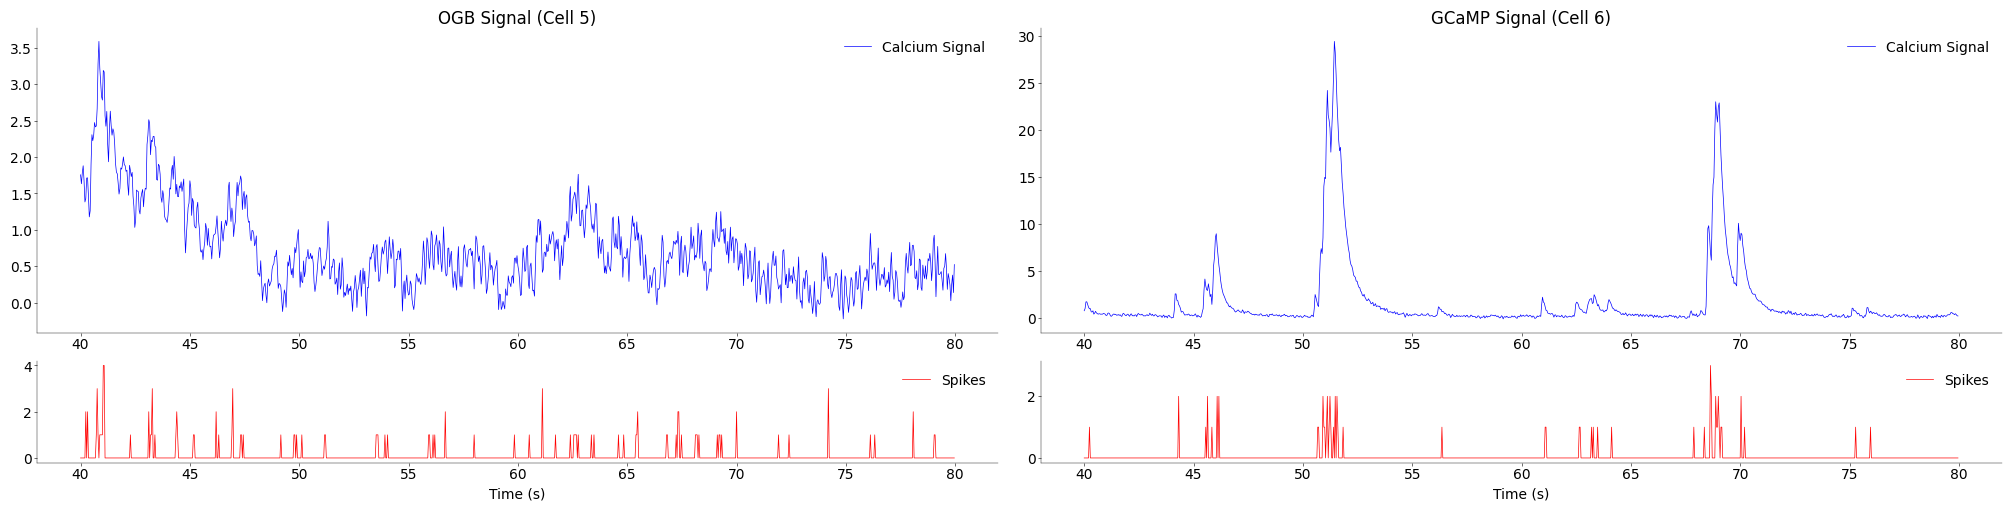

In [130]:
# plot example data
fig, axs = plt.subplots(
    2, 2, figsize=(20, 5), height_ratios=[3, 1], layout="constrained"
)

# chose time window for data
time_idx = [1000, 2000]
time = np.arange(time_idx[0] / 25, time_idx[1] / 25, 0.04)  # 0.04s time step (25Hz)

# use cell 5 from the OGB dataset
ogb_calcium_cell5 = ogb_calcium[time_idx[0] : time_idx[1], 5]

# add a small x offset to the spikes to make them aligned
offset_ogb = -8  # use the value you provided above
ogb_spikes_cell5 = ogb_spikes.iloc[
    time_idx[0] + offset_ogb : time_idx[1] + offset_ogb, 5
]

axs[0, 0].plot(time, ogb_calcium_cell5, color="blue", label="Calcium Signal", lw=0.5)
axs[0, 0].set_title("OGB Signal (Cell 5)")
axs[1, 0].plot(time, ogb_spikes_cell5, color="red", label="Spikes", lw=0.5)


# use cell 6 from the GCaMP dataset
gcamp_calcium_cell6 = gcamp_calcium[time_idx[0] : time_idx[1], 6]

# add a small x offset to the spikes to make them aligned
offset_gcamp = -5  # use the value you provided above
gcamp_spikes_cell6 = gcamp_spikes.iloc[
    time_idx[0] + offset_gcamp : time_idx[1] + offset_gcamp, 6
]

axs[0, 1].plot(time, gcamp_calcium_cell6, color="blue", label="Calcium Signal", lw=0.5)
axs[0, 1].set_title("GCaMP Signal (Cell 6)")
axs[1, 1].plot(time, gcamp_spikes_cell6, color="red", label="Spikes", lw=0.5)

[axs[1, i].set_xlabel("Time (s)") for i in range(2)]
[axs[i, j].legend() for i in range(2) for j in range(2)]
plt.show()

## Bonus Task (Optional): Calcium preprocessing

To improve the quality of the inferred spike trains, further preprocessing steps can undertaken. This includes filtering and smoothing of the calcium trace.

Implement a suitable filter and local averaging procedure as discussed in the lecture. Explain your choices and discuss how it helps!

_Grading: 1 BONUS point_

_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

In [131]:
# --------------------------------
# Bonus Task: Smoothering and Filtering (1 pt)
# --------------------------------

# filter the signal with a butterworth filter
butter = signal.butter(4, 10, btype="low", fs=25, output="sos")
# filter the signal with a butterworth filter
ogb_calcium_filt = signal.sosfiltfilt(butter, ogb_calcium, axis=0)
gcamp_calcium_filt = signal.sosfiltfilt(butter, gcamp_calcium, axis=0)

Breaking for cell 0 at iteration 1298 due to convergence
Breaking for cell 1 at iteration 817 due to convergence
Breaking for cell 2 at iteration 1212 due to convergence
Breaking for cell 3 at iteration 736 due to convergence
Breaking for cell 4 at iteration 1150 due to convergence
Breaking for cell 5 at iteration 1284 due to convergence
Breaking for cell 6 at iteration 703 due to convergence
Breaking for cell 7 at iteration 696 due to convergence
Breaking for cell 8 at iteration 966 due to convergence
Breaking for cell 9 at iteration 974 due to convergence
Breaking for cell 10 at iteration 1062 due to convergence
Breaking for cell 0 at iteration 403 due to convergence
Breaking for cell 1 at iteration 524 due to convergence
Breaking for cell 2 at iteration 538 due to convergence
Breaking for cell 3 at iteration 213 due to convergence
Breaking for cell 4 at iteration 445 due to convergence
Breaking for cell 5 at iteration 401 due to convergence
Breaking for cell 6 at iteration 535 due t

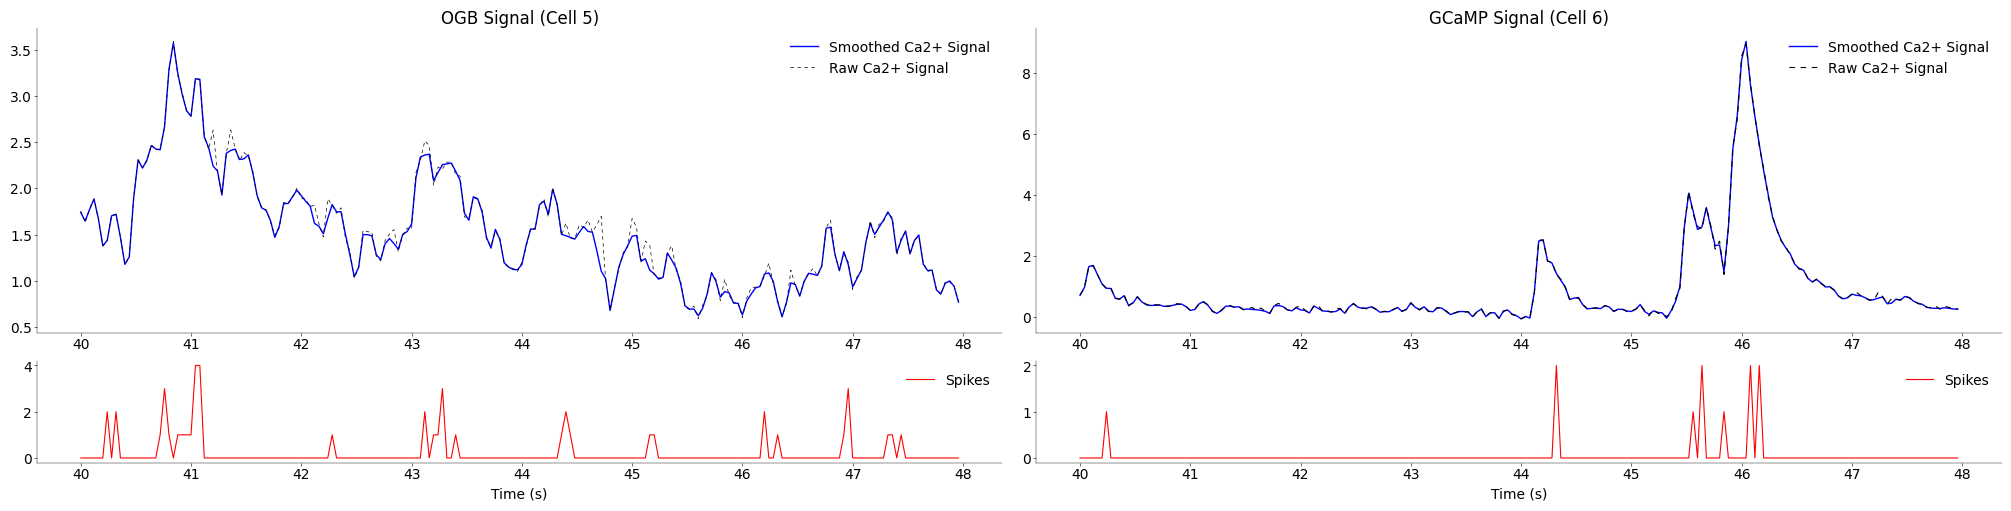

In [ ]:
# smooth by the iterative approach from Yaksi & Fredrich 2006
def yaksi_friedrich_smooth(
    calcium_data: np.ndarray,
    thrnoise: float = 1.0,
    sm_iter: int = 3,
    max_iterations: int = 5000,
) -> np.ndarray:
    """
    Apply iterative smoothing approach from Yaksi & Friedrich 2006.

    Parameters:
    -----------
    calcium_data : np.ndarray
        Filtered calcium data, shape (time_points, cells).
    thrnoise : float
        Noise threshold. If the "amplitude" of a peak (difference to
        the preceding peak's value) is less than this, smoothing occurs.
    max_iterations : int
        Maximum number of iterations for the overall procedure.

    Returns:
    --------
    np.ndarray
        Smoothed calcium data.
    """
    smoothed_data_all_cells = calcium_data.copy()

    for cell_idx in range(calcium_data.shape[1]):
        trace = smoothed_data_all_cells[:, cell_idx].copy()

        for iteration_num in range(max_iterations):
            trace_at_iteration_start = trace.copy()

            # 1. Identify all peaks in the current trace
            peak_indices, _ = signal.find_peaks(trace, prominence=0.001, distance=1)

            if len(peak_indices) < 2:
                print(
                    "Breaking for cell",
                    cell_idx,
                    "at iteration",
                    iteration_num,
                    "due to less than 2 peaks",
                )
                # Need at least two peaks to calculate amplitude as difference to preceding peak
                break

            # 2. Calculate "amplitudes" as defined: difference between signal amplitude at each peak and the preceding peak.
            # These amplitudes are associated with peak_indices[1], peak_indices[2], ...
            peak_values = trace[peak_indices]
            diff_amplitudes_raw = peak_values[1:] - peak_values[:-1]
            abs_diff_amplitudes = np.abs(diff_amplitudes_raw)

            if not abs_diff_amplitudes.size:
                print(
                    "Breaking for cell",
                    cell_idx,
                    "at iteration",
                    iteration_num,
                    "due to empty abs_diff_amplitudes array",
                )
                break  # No amplitudes calculated

            # 3. Find the peak pmin with the smallest absolute amplitude
            min_abs_amp_value = np.min(abs_diff_amplitudes)

            if min_abs_amp_value >= thrnoise:
                # Smallest amplitude is not below threshold, stop for this cell
                print(
                    "Breaking for cell",
                    cell_idx,
                    "at iteration",
                    iteration_num,
                    "due to min_abs_amp_value larger than threshold",
                )
                break

            # Find the index (in diff_amplitudes_raw/abs_diff_amplitudes) of the first occurrence of min_abs_amp_value
            idx_of_min_amp_in_array = np.where(
                abs_diff_amplitudes == min_abs_amp_value
            )[0][0]

            # pmin is the peak *for which* this amplitude was calculated.
            # If diff_amplitudes_raw[j] = peak_values[j+1] - peak_values[j],
            # then pmin corresponds to peak_values[j+1] (i.e., peak_indices[j+1])
            pmin_k_in_peak_indices = idx_of_min_amp_in_array + 1
            # pmin_global_trace_idx = peak_indices[pmin_k_in_peak_indices] # Actual trace index of pmin

            # 4. Define the trace segment: "between the peaks adjacent to pmin"
            # Peak preceding pmin (this is peak_indices[idx_of_min_amp_in_array])
            segment_start_trace_idx = peak_indices[pmin_k_in_peak_indices - 1]

            # Peak succeeding pmin (this is peak_indices[idx_of_min_amp_in_array + 2] if it exists)
            if pmin_k_in_peak_indices + 1 < len(peak_indices):
                segment_end_trace_idx = peak_indices[pmin_k_in_peak_indices + 1]
            else:
                # pmin was the second to last peak, or last peak with a calculable diff_amplitude.
                # The segment extends to the end of the trace.
                segment_end_trace_idx = len(trace) - 1

            if (
                segment_start_trace_idx >= segment_end_trace_idx
            ):  # Should not happen if len(peak_indices) >=2
                continue

            # 5. Smooth the segment: trace[segment_start_trace_idx : segment_end_trace_idx + 1]
            current_segment_to_smooth = trace[
                segment_start_trace_idx : segment_end_trace_idx + 1
            ].copy()

            # Identify points for smoothing: peaks within this segment + endpoints of the segment
            # These are relative indices within current_segment_to_smooth
            segment_peak_indices_rel, _ = signal.find_peaks(current_segment_to_smooth)

            points_to_smooth_rel_indices = set(segment_peak_indices_rel)
            points_to_smooth_rel_indices.add(0)  # First point of the segment
            if len(current_segment_to_smooth) > 1:
                points_to_smooth_rel_indices.add(
                    len(current_segment_to_smooth) - 1
                )  # Last point

            # Perform smoothing 3 times
            processed_sub_segment = current_segment_to_smooth.copy()
            for _ in range(sm_iter):  # 3 smoothing iterations on the sub-segment
                prev_iter_sub_segment_state = processed_sub_segment.copy()
                for rel_idx in sorted(list(points_to_smooth_rel_indices)):
                    val_at_idx = prev_iter_sub_segment_state[rel_idx]
                    if (
                        0 < rel_idx < len(processed_sub_segment) - 1
                    ):  # Mid-segment point
                        val_prev = prev_iter_sub_segment_state[rel_idx - 1]
                        val_next = prev_iter_sub_segment_state[rel_idx + 1]
                        processed_sub_segment[rel_idx] = (
                            val_prev + val_at_idx + val_next
                        ) / 3.0
                    elif rel_idx == 0 and len(processed_sub_segment) > 1:  # First point
                        val_next = prev_iter_sub_segment_state[rel_idx + 1]
                        processed_sub_segment[rel_idx] = (val_at_idx + val_next) / 2.0
                    elif (
                        rel_idx == len(processed_sub_segment) - 1 and rel_idx > 0
                    ):  # Last point
                        val_prev = prev_iter_sub_segment_state[rel_idx - 1]
                        processed_sub_segment[rel_idx] = (val_prev + val_at_idx) / 2.0
                    # If segment has only 1 point, or point is isolated, it remains unchanged by averaging.

            # Replace the original trace segment with the smoothed segment
            trace[segment_start_trace_idx : segment_end_trace_idx + 1] = (
                processed_sub_segment
            )

            # Check if trace changed; if not, convergence for this cell
            if np.allclose(trace, trace_at_iteration_start):
                print(
                    "Breaking for cell",
                    cell_idx,
                    "at iteration",
                    iteration_num,
                    "due to convergence",
                )
                break

        smoothed_data_all_cells[:, cell_idx] = trace

    return smoothed_data_all_cells


# Apply to the filtered data
ogb_calcium_smooth = yaksi_friedrich_smooth(ogb_calcium_filt)
gcamp_calcium_smooth = yaksi_friedrich_smooth(gcamp_calcium_filt)

# create new time index for the smoothed data (smaller time window to see the effect of smoothing)
time_idx_smooth = [1000, 1200]

time_smooth = np.arange(
    time_idx_smooth[0] / 25, time_idx_smooth[1] / 25, 0.04
)  # 0.04s time step (25Hz)

# plot example data
fig, axs = plt.subplots(
    2, 2, figsize=(20, 5), height_ratios=[3, 1], layout="constrained"
)

# use cell 5 from the OGB dataset
ogb_calcium_cell5_smooth = ogb_calcium_smooth[
    time_idx_smooth[0] : time_idx_smooth[1], 5
]

# adapt the old cells to the new time window
ogb_calcium_cell5 = ogb_calcium[time_idx_smooth[0] : time_idx_smooth[1], 5]

# add a small x offset to the spikes to make them aligned
offset_ogb = -8  # use the value you provided above
ogb_spikes_cell5 = ogb_spikes.iloc[
    time_idx_smooth[0] + offset_ogb : time_idx_smooth[1] + offset_ogb, 5
]

axs[0, 0].plot(
    time_smooth, ogb_calcium_cell5_smooth, color="blue", label="Smoothed Ca2+ Signal"
)
# ad  the old plot for comparison as dash lines
axs[0, 0].plot(
    time_smooth,
    ogb_calcium_cell5,
    "k--",
    dashes=[5, 5],
    lw=0.5,
    label="Raw Ca2+ Signal",
)

axs[0, 0].set_title("OGB Signal (Cell 5)")
axs[1, 0].plot(time_smooth, ogb_spikes_cell5, color="red", label="Spikes", lw=0.8)


# use cell 6 from the GCaMP dataset
gcamp_calcium_cell6_smooth = gcamp_calcium_smooth[
    time_idx_smooth[0] : time_idx_smooth[1], 6
]

# adapt the old cells to the new time window
gcamp_calcium_cell6 = gcamp_calcium[time_idx_smooth[0] : time_idx_smooth[1], 6]
# add a small x offset to the spikes to make them aligned
offset_gcamp = -5  # use the value you provided above
gcamp_spikes_cell6 = gcamp_spikes.iloc[
    time_idx_smooth[0] + offset_gcamp : time_idx_smooth[1] + offset_gcamp, 6
]

axs[0, 1].plot(
    time_smooth, gcamp_calcium_cell6_smooth, color="blue", label="Smoothed Ca2+ Signal"
)
axs[0, 1].plot(
    time_smooth,
    gcamp_calcium_cell6,
    "k--",
    lw=0.8,
    dashes=[5, 5],
    label="Raw Ca2+ Signal",
)
axs[0, 1].set_title("GCaMP Signal (Cell 6)")
axs[1, 1].plot(time_smooth, gcamp_spikes_cell6, color="red", label="Spikes", lw=0.8)


[axs[1, i].set_xlabel("Time (s)") for i in range(2)]
[axs[i, j].legend() for i in range(2) for j in range(2)]

plt.show()

Ideally, application of the low-pass filter helps to remove high-frequency noise (especially in the OGB dataset). In this sense the smoothing procedure is intended to increase local signal-to-noise ratio. However in the time frime seen in the figure above, the difference between the raw data and smoothed calcium signal is marginal, espceially for the GCamp6f dataset where the data seems to be already stable and peaks in fluorescence coincide well with the spikes. 

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). Note there can be no negative rates! Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this. Explain your results and your choice of kernel.

*Grading: 6 pts*


In [ ]:
def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------

    return sp_hat

In [ ]:
# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")


### Questions (1 pt)
1) Explain how you constructed the kernels

YOUR ANSWER HERE

2) How do the indicators / kernels compare?

YOUR ANSWER HERE

3) What are pros and cons of each indicator?

YOUR ANSWER HERE

In [ ]:
# ----------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB and GCamP cells.
# What do you notice? Why is that? (3 pts)
# ----------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamp Cell


## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 3 pts*



In [ ]:
# run this cell to download the oopsi.py file and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
import oopsi

In [ ]:
# ----------------------------------------------------------------------
# Apply one of the advanced algorithms to the OGB and GCamp Cells (1 pt)
# ----------------------------------------------------------------------

In [ ]:
# -------------------------------------------------------------------------------
# Plot the results for the OGB and GCamp Cells and describe the results (1+1 pts)
# -------------------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamP Cell

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package. Note these functions provide useful options for formatting the
plots. See their documentation, i.e. `sns.boxplot?`.

*Grading: 5 pts*


First, evaluate on OGB data and create OGB dataframe. Then repeat for GCamp and combine the two dataframes.

In [ ]:
# ----------------------------------------------------------
# Evaluate the algorithms on the OGB and GCamp cells (2 pts)
# ----------------------------------------------------------

In [ ]:
# -------------------------------
# Construct the dataframe (1 pts)
# -------------------------------

Combine both dataframes. Plot the performance of each indicator and algorithm. You should only need a single plot for this.

In [ ]:
# ----------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described. (1 pt)
# Describe and explain the results briefly. (1 pt)
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
